# Environment and RL Agent Controller for a Thermostat

This is a toy example of a room with a heater.  When the heater is off, the temperature will decay to 0.0, and when it is on, it will rise to 1.0.  The decay and rise is not instantaneous, but has exponential decay behavior in time given by the following formula:

    temperature[i + 1] = heater[i] + (temperature[i] - heater[i]) * exp(-1/tau)

Where:

    temperature[i] is the temperature at timestep i (between 0 and 1).
    heater[i] is the applied heater, 0 when not applied, 1 when applied.
    tau is the characteristic heat decay constant.

So, when the heater is off, the temperature will decay towards 0, and when the heater is on, it will rise towards 1.  When the heater is toggled on/off, it will drift towards 1/0.

Here is a sample plot of what the temperature response looks like when the heater is on for a while, then off for a while.  You will see the characteristic rise and decay of the temperature to the response.

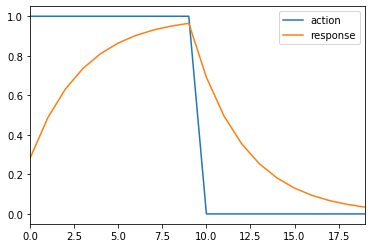

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

## Compute the response for a given action and current temperature
def respond(action, current_temp, tau):
    return action + (current_temp - action) * math.exp(-1.0/tau)

## Actions of a series of on, then off
sAction = pd.Series(np.array([1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0]))
sResponse = np.zeros(sAction.size)

## Update the response with the response to the action
for i in range(sAction.size):
    ## Get last response
    if i == 0:
        last_response = 0
    else:
        last_response = sResponse[i - 1]
    sResponse[i] = respond(sAction[i], last_response, 3.0)

## Assemble and plot
df = pd.DataFrame(list(zip(sAction, sResponse)), columns=['action', 'response'])
df.plot()

## Goal and Reward
The goal here is to make an agent that will take actions that will keep the temperature between 0.4 and 0.6.

We make a reward function to reflect our goal.  When the temperature is between 0.4 and 0.6, we set the reward as 0.0.  When the temperature is outside of this band, we set the reward to be the negative distance the temperature is from its closest band.  So if the temperature is 0.1, then the reward is -(0.4 - 0.1) = -0.3, and if it is 0.8, then the reward is -(0.8 - 0.6) = -0.2.

Let's chart the reward vs. temperature to show what is meant:

Text(0.5, 1.0, 'Reward vs. Temperature')

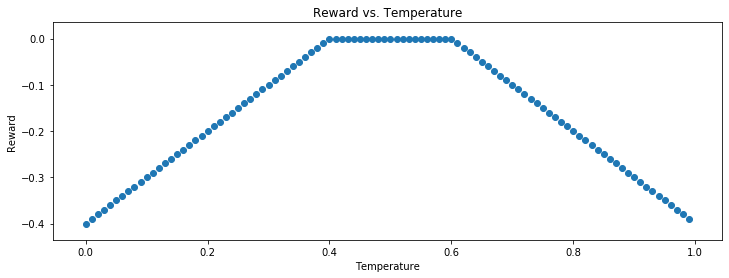

In [2]:

def reward(temp):
        delta = abs(temp - 0.5)
        if delta < 0.1:
            return 0.0
        else:
            return -delta + 0.1

temps = [x * 0.01 for x in range(100)]
rewards = [reward(x) for x in temps]

fig=plt.figure(figsize=(12, 4))

plt.scatter(temps, rewards)
plt.xlabel('Temperature')
plt.ylabel('Reward')
plt.title('Reward vs. Temperature')

# Environment Setup

The environment responds to actions.  It is what keeps track of the temperature state of the room, returns the reward for being in that temperature state, and tells you if the episode is over or not (in this case, we just set a max episode length that can happen).

Here is the gist of the flow:

- Create an environment by calling `Environment.create()`, see below, telling it to use the class you created for this (here, the ThermostatEnvironment) and the max timesteps per episode.  The enviroment is assigned to the name `environment`.
- Initialize the environment `environment` by calling `environment.reset()`.  This will do stuff, most importantly, it will initialize the `timestep` attribute to 0.
- When you want to take an action on the current state of the environment, you will call `environment.execute(<action-value>)`.  If you want to have the heater off, you call `environment.execute(0)`, and if you want to have the heater on, you call `environment.execute(1)`.
- What the `execute()` call returns is a tuple with 3 entries:
    - __state__.  In this case, the state is the current temperature that results from taking the action.  If you turn on the heater, the temperature will rise from the previous state, and if the heater was turned off, the temperature will fall from the previous state.  This should be kept as a numpy array, even though it seems like overkill with a single value for the state coming back.  For more complex examples beyond this thermostat, there will be more than 1 component to the state.
    - __terminal__.  This is a True/False value.  It is True if the episode terminated.  In this case, that will happen once you exceed the max number of steps you have set.  Otherwise, it will be False, which lets the agent know that it can take further steps.
    - __reward__.  This is the reward for taking the action you took.

Below, to train the agent, you will have the agent take actions on the environment, and the environment will return these signals so that the agent can self-train to optimize its reward.

In [3]:
###-----------------------------------------------------------------------------
## Imports
from tensorforce.environments import Environment
from tensorforce.agents import Agent
import numpy as np
import math



###-----------------------------------------------------------------------------
### Environment definition
class ThermostatEnvironment(Environment):
    """This class defines a simple thermostat environment.  It is a room with
    a heater, and when the heater is on, the room temperature will approach
    the max heater temperature (usually 1.0), and when off, the room will
    decay to a temperature of 0.0.  The exponential constant that determines
    how fast it approaches these temperatures over timesteps is tau.
    """
    def __init__(self):
        ## Some initializations.  Will eventually parameterize this in the constructor.
        # self.timestep = 0
        self.tau = 3.0
        #self.current_temp = 0.0
        # self.current_temp = np.array([np.random.random(size=(1,))])
        self.current_temp = np.random.random(size=(1,))

        super().__init__()


    def states(self):
        return dict(type='float', shape=(1,))


    def actions(self):
        """Action 0 means no heater, temperature approaches 0.0.  Action 1 means
        the heater is on and the room temperature approaches 1.0.
        """
        return dict(type='int', num_values=2)


    # Optional, should only be defined if environment has a natural maximum
    # episode length
    def max_episode_timesteps(self):
        # return 100
        return super().max_episode_timesteps()


    # Optional
    def close(self):
        super().close()


    def reset(self):
        """Reset state.
        """
        # state = np.random.random(size=(1,))
        self.timestep = 0
        self.current_temp = np.random.random(size=(1,))
        return self.current_temp


    def response(self, action):
        """Respond to an action.  When the action is 1, the temperature
        exponentially decays approaches 1.0.  When the action is 0,
        the current temperature decays towards 0.0.
        """
        # return np.array([action + (self.current_temp - action) * math.exp(-1.0 / self.tau)])
        return action + (self.current_temp - action) * math.exp(-1.0 / self.tau)


    def reward_compute(self):
        """ The reward here is 0 if the current temp is between 0.4 and 0.6,
        else it is distance the temp is away from the 0.4 or 0.6 boundary.
        """
        delta = abs(self.current_temp - 0.5)
        if delta < 0.1:
            return 0.0
        else:
            return -delta[0] + 0.1


    def execute(self, actions):
        ## Check the action is either 0 or 1 -- heater on or off.
        assert actions == 0 or actions == 1

        ## Increment timestamp
        self.timestep += 1
        
        ## Update the current_temp
        self.current_temp = self.response(actions)
        
        ## Compute the reward
        reward = self.reward_compute()

        ## The only way to go terminal is to exceed max_episode_timestamp.
        ## terminal == 0 means episode is not done
        ## terminal == 1 means it is done.
        terminal = False
        if self.timestep > self.max_episode_timesteps():
            terminal = True
        
        return self.current_temp, terminal, reward

###-----------------------------------------------------------------------------
### Create the environment
###   - Tell it the environment class
###   - Set the max timestamps that can happen per episode
environment = environment = Environment.create(
    environment=ThermostatEnvironment,
    max_episode_timesteps=100)


# Agent setup

Here we configure a type of agent to learn against this environment.  There are many agent configurations to choose from, which we will not cover here.  We will not discuss what type of agent to choose here -- we will just take a basic agent to train.

In [4]:
agent = Agent.create(
    agent='tensorforce', environment=environment, update=64,
    objective='policy_gradient', reward_estimation=dict(horizon=1)
)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


# Check: Untrained Agent Performance

Let's see how the untrained agent performs on the environment.  The red horizontal lines are the target bands for the temperature.

The agent doesn't take actions to try and get the temperature within the bands.

C:\Users\matth\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Text(0.5, 1.0, 'Temperature vs. Timestep')

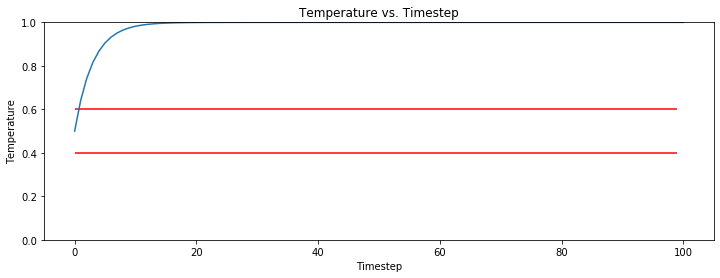

In [5]:
### Initialize
environment.reset()
environment.environment.current_temp = np.array([0.5])
states = environment.environment.current_temp

internals = agent.initial_internals()
terminal = False

### Run an episode
temp = [environment.environment.current_temp[0]]
while not terminal:
    actions, internals = agent.act(states=states, internals=internals, evaluation=True)
    states, terminal, reward = environment.execute(actions=actions)
    temp += [states[0]]
    
### Plot the run
fig=plt.figure(figsize=(12, 4))
plt.plot(range(len(temp)), temp)
plt.hlines(y=0.4, xmin=0, xmax=99, color='r')
plt.hlines(y=0.6, xmin=0, xmax=99, color='r')
plt.axes().set_ylim([0.0, 1.0])
plt.xlabel('Timestep')
plt.ylabel('Temperature')
plt.title('Temperature vs. Timestep')

# Train the agent

Here we train the agent against episodes of interacting with the environment.

In [6]:
# Train for 200 episodes
for _ in range(200):
    states = environment.reset()
    terminal = False
    while not terminal:
        actions = agent.act(states=states)
        states, terminal, reward = environment.execute(actions=actions)
        agent.observe(terminal=terminal, reward=reward)

# Check: Trained Agent Performance

You can plainly see that this is toggling the heater on/off to keep the temperature within the target band!

C:\Users\matth\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Text(0.5, 1.0, 'Temperature vs. Timestep')

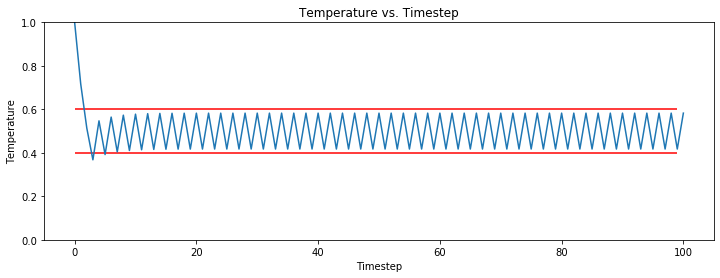

In [7]:
### Initialize
environment.reset()
environment.environment.current_temp = np.array([1.0])
states = environment.environment.current_temp

internals = agent.initial_internals()
terminal = False

### Run an episode
temp = [environment.environment.current_temp[0]]
while not terminal:
    actions, internals = agent.act(states=states, internals=internals, evaluation=True)
    states, terminal, reward = environment.execute(actions=actions)
    temp += [states[0]]

### Plot the run
fig=plt.figure(figsize=(12, 4))
plt.plot(range(len(temp)), temp)
plt.hlines(y=0.4, xmin=0, xmax=99, color='r')
plt.hlines(y=0.6, xmin=0, xmax=99, color='r')
plt.axes().set_ylim([0.0, 1.0])
plt.xlabel('Timestep')
plt.ylabel('Temperature')
plt.title('Temperature vs. Timestep')